In [1]:
import pandas as pd
import pickle as pk

In [2]:
"""
class GroundMotionDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label"""

'\nclass GroundMotionDataset(Dataset):\n    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):\n        self.img_labels = pd.read_csv(annotations_file)\n        self.img_dir = img_dir\n        self.transform = transform\n        self.target_transform = target_transform\n\n    def __len__(self):\n        return len(self.img_labels)\n\n    def __getitem__(self, idx):\n        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])\n        image = read_image(img_path)\n        label = self.img_labels.iloc[idx, 1]\n        if self.transform:\n            image = self.transform(image)\n        if self.target_transform:\n            label = self.target_transform(label)\n        return image, label'

In [3]:
ground_motion = pd.read_pickle("data/processed_ground_motion_PGA.pkl")

In [4]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import seaborn as sns
sns.set()
sns.set_theme(style="whitegrid")

In [5]:
y = np.log(ground_motion['PGA (g)'].values)

In [6]:
X = ground_motion[['Earthquake Magnitude', 'EpiD (km)', 'Vs30 (m/s) selected for analysis']].values

In [7]:
X_new = np.zeros([X.shape[0],X.shape[1]])
X_new[:,0] = np.log(ground_motion['Earthquake Magnitude'].values)
X_new[:,1] = np.log(ground_motion['EpiD (km)'].values)
X_new[:,2] = ground_motion['Vs30 (m/s) selected for analysis'].values
#X = X_new

In [8]:
y

array([ -1.85138209,  -3.06996025,  -3.19513488, ..., -10.25699609,
       -10.51192601,  -4.55866835])

In [9]:
# We added shuffling to introduce stochasticity
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True)

In [10]:
X_train

array([[  3.94    , 131.604   , 417.99    ],
       [  4.2     ,   7.359601, 285.93    ],
       [  3.69    ,  52.46967 , 646.      ],
       ...,
       [  6.2     ,  98.15    , 288.3     ],
       [  4.3     ,  65.1804  , 402.6     ],
       [  6.63    , 179.72    , 366.93    ]])

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [12]:
class NonlinearRegressionModel01(nn.Module):
    def __init__(self):
        super(NonlinearRegressionModel01, self).__init__()
        self.hidden1 = nn.Linear(3, 30)
        self.hidden2 = nn.Linear(30, 30)
        self.hidden3 = nn.Linear(30, 30)
        self.output = nn.Linear(30, 1) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.output(x)
        return x

class NonlinearRegressionModel02(nn.Module):
    def __init__(self):
        super(NonlinearRegressionModel02, self).__init__()
        self.hidden1 = nn.Linear(3, 300)
        self.hidden2 = nn.Linear(300, 200)
        self.hidden3 = nn.Linear(200, 100)
        self.hidden4 = nn.Linear(100, 50)
        self.hidden5 = nn.Linear(50, 10)
        self.hidden6 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 1) 
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.relu(self.hidden4(x))
        x = self.relu(self.hidden5(x))
        x = self.relu(self.hidden6(x))
        x = self.output(x)
        return x

In [13]:
model01 = NonlinearRegressionModel02()
# Define loss and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model01.parameters(), lr=0.0001)  # Adam optimizer

# Training loop
n_epochs = 1000   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history_train = []
history_test = []
for epoch in range(n_epochs):
    outputs = model01(X_train)
    loss = loss_fn(outputs, y_train)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
    y_pred = model01(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history_test.append(mse)
    y_pred = model01(X_train)
    mse = loss_fn(y_pred, y_train)
    mse = float(mse)
    history_train.append(mse)
loss01 = loss.item()

Epoch [10/1000], Loss: 38.1460
Epoch [20/1000], Loss: 35.7647
Epoch [30/1000], Loss: 33.1081
Epoch [40/1000], Loss: 29.4987
Epoch [50/1000], Loss: 22.8682
Epoch [60/1000], Loss: 14.2105
Epoch [70/1000], Loss: 8.0605
Epoch [80/1000], Loss: 7.4887
Epoch [90/1000], Loss: 7.2714
Epoch [100/1000], Loss: 6.9953
Epoch [110/1000], Loss: 6.8837
Epoch [120/1000], Loss: 6.7402
Epoch [130/1000], Loss: 6.6242
Epoch [140/1000], Loss: 6.5058
Epoch [150/1000], Loss: 6.3877
Epoch [160/1000], Loss: 6.2580
Epoch [170/1000], Loss: 6.1456
Epoch [180/1000], Loss: 6.0462
Epoch [190/1000], Loss: 5.9593
Epoch [200/1000], Loss: 5.8846
Epoch [210/1000], Loss: 5.8221
Epoch [220/1000], Loss: 5.7712
Epoch [230/1000], Loss: 5.7289
Epoch [240/1000], Loss: 5.6906
Epoch [250/1000], Loss: 5.6539
Epoch [260/1000], Loss: 5.6261
Epoch [270/1000], Loss: 5.6034
Epoch [280/1000], Loss: 5.5838
Epoch [290/1000], Loss: 5.5644
Epoch [300/1000], Loss: 5.5456
Epoch [310/1000], Loss: 5.5210
Epoch [320/1000], Loss: 5.5039
Epoch [330/

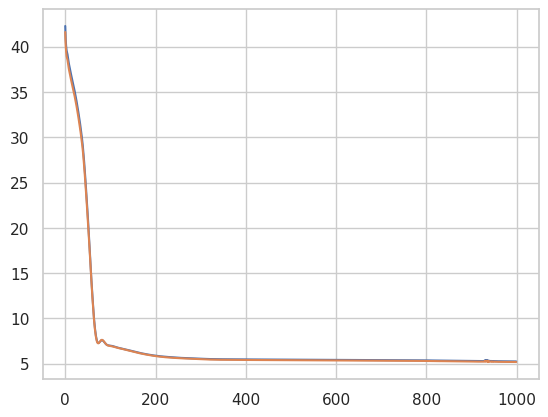

In [14]:
plt.plot(history_train)
plt.plot(history_test)

In [15]:
interest_index = (ground_motion['Earthquake Magnitude'] > 6.5) & (ground_motion['Earthquake Magnitude'] < 7.5)

exp = ground_motion[interest_index][['Earthquake Magnitude', 'EpiD (km)', 'Vs30 (m/s) selected for analysis']].values
exp = torch.tensor(exp, dtype=torch.float32)
exp_pred = model01(exp)

exp2 = np.zeros([101,3])
exp2[:,0] = np.linspace(4,9,101)
exp2[:,1] = 10
exp2[:,2] = 360
exp2 = torch.tensor(exp2, dtype=torch.float32)
exp2_pred = model01(exp2)

/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


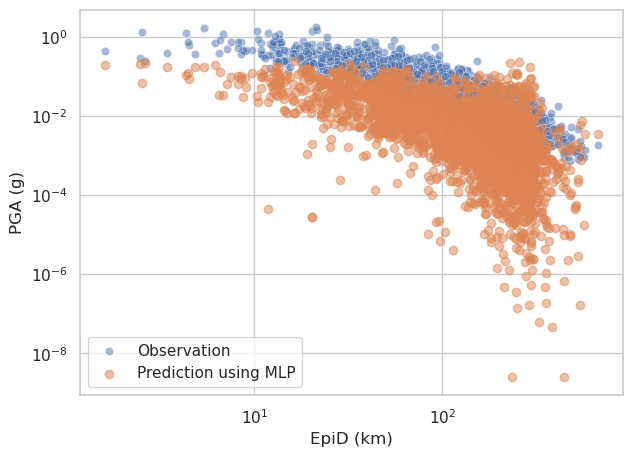

In [16]:
# plt.loglog(dist, torch.exp(exp_pred).detach().numpy())
f, ax = plt.subplots(figsize=(7, 5))
ax.set(xscale="log", yscale="log")
sns.scatterplot(data=ground_motion[interest_index], x="EpiD (km)", y="PGA (g)",  alpha=0.5, label='Observation')
plt.scatter(ground_motion[interest_index]['EpiD (km)'], torch.exp(exp_pred).detach().numpy(),  alpha=0.5, label='Prediction using MLP')
plt.legend()
plt.savefig('Interim_Report/PGA_Pred.png', bbox_inches='tight')


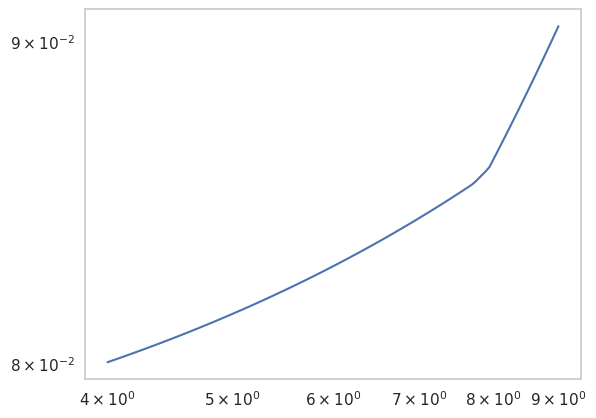

In [17]:
plt.loglog(np.linspace(4,9,101), torch.exp(exp2_pred).detach().numpy())

In [18]:
plt.plot(dist, torch.exp(exp_pred).detach().numpy())

NameError: name 'dist' is not defined

In [ ]:
exp = ground_motion[interest_index]['Earthquake Magnitude', 'EpiD (km)', 'Vs30 (m/s) selected for analysis'].values